# Conv-3D: 3-D MNIST with TensorFlow2.8

You can refer to 3D MNIST dataset [here](https://www.kaggle.com/daavoo/3d-mnist#).

Example codes can be referenced [here](https://www.kaggle.com/shivamb/3d-convolutions-understanding-use-case) & [here](https://github.com/christianversloot/machine-learning-articles/blob/main/a-simple-conv3d-example-with-keras.md)

In [ ]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

In [16]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model

import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [3]:
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"number of GPUs available = {num_gpus}")

# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 0
No GPU found


In [4]:
# Specify hyper-parameters-
batch_size = 64
no_epochs = 35
learning_rate = 0.001
num_classes = 10
validation_split = 0.2

#### Define some helper function

In [5]:
# Convert 1D vector into 3D values, provided by the 3D MNIST authors at
# https://www.kaggle.com/daavoo/3d-mnist
def array_to_color(array, cmap="Oranges"):
    '''
    The imported data has only 1 channel. This function converts the data into 3 channel - RGB format.
    This ensures resemblence with the original 2D scenario.
    '''
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]


In [6]:
# Reshape data into format that can be handled by Conv3D layers.
# Courtesy of Sam Berglin; Zheming Lian; Jiahui Jang - University of Wisconsin-Madison
# Report - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/Report.pdf
# Code - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/network_final_version.ipynb
def rgb_data_transform(data):
    '''
    This function reshapes the data, which per sample comes in as 1-D shape: (4096,)  - 16x16x16 pixels = 4096 pixels,
    which is a 1-D array. This function reshapes the data into three-channeled, four-dimensional 16x16x16x3 format by
    making use of 'array_to_color()'. The Conv3D function can now handle the data.
    '''
    data_t = []
    for i in range(data.shape[0]):
        data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
    return np.asarray(data_t, dtype=np.float32)


### 3-D MNIST data preparation

In [11]:
# Load the HDF5 data file
with h5py.File("3D_MNIST-archive/full_dataset_vectors.h5", "r") as hf:

    # Split the data into training, validation features & targets/labels-
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    y_test = hf["y_test"][:]

    # Determine sample shape-
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format-
    # Transform & reshape data from one-channeled (4096,) format into three-channeled
    # (16, 16, 16, 3) format.
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

    # Convert target vectors to categorical targets (format)-
    y_train = to_categorical(y_train).astype(np.integer)
    y_test = to_categorical(y_test).astype(np.integer)
    

C:\Users\Arjun\AppData\Local\Temp\ipykernel_8504\1228886426.py:20: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y_train = to_categorical(y_train).astype(np.integer)
C:\Users\Arjun\AppData\Local\Temp\ipykernel_8504\1228886426.py:21: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y_test = to_categorical(y_test).astype(np.integer)


In [12]:
# Sanity check-
X_train.shape, X_test.shape

((10000, 16, 16, 16, 3), (2000, 16, 16, 16, 3))

In [13]:
# Sanity check-
y_train.shape, y_test.shape

((10000, 10), (2000, 10))

In [19]:
print(f"Maximum pixel value = {X_train.max():.3f} & minimum pixel value = {X_train.min():.3f}")

Maximum pixel value = 1.000 & minimum pixel value = 0.004


### Define Conv3D architecture

In [27]:
class Conv3D_Architecture(Model):
    def __init__(self):
        super(Conv3D_Architecture, self).__init__()
        
        self.conv1 = Conv3D(
            filters = 32, kernel_size = (3, 3, 3),
            activation = None, kernel_initializer = 'he_uniform',
            input_shape = sample_shape
        )
        
        self.pool1 = MaxPooling3D(
            pool_size = (2, 2, 2)
        )
        
        self.conv2 = Conv3D(
            filters = 64, kernel_size = (3, 3, 3),
            activation = None, kernel_initializer = 'he_uniform'
        )
        '''
        self.pool2 = MaxPooling3D(
            pool_size = (2, 2, 2)
        )
        '''
        self.flatten = Flatten()
        
        self.dense1 = Dense(
            units = 256, activation = None,
            kernel_initializer = 'he_uniform'
        )
        
        self.output_layer = Dense(
            units = num_classes, activation = None
        )
        
        
    def call(self, x):
        x = tf.nn.relu(self.conv1(x))
        x = self.pool1(x)
        x = tf.nn.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = tf.nn.relu(self.dense1(x))
        x = tf.nn.softmax(self.output_layer(x))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"first conv3D output shape: {x.shape}")
        x = self.pool1(x)
        print(f"first MaxPooling3D output shape: {x.shape}")
        x = self.conv2(x)
        print(f"second conv3D output shape: {x.shape}")
        x = self.pool1(x)
        print(f"second MaxPooling3D output shape: {x.shape}")
        x = self.flatten(x)
        print(f"Flattened output shape: {x.shape}")
        x = self.dense1(x)
        print(f"first dense output shape: {x.shape}")
        x = self.output_layer(x)
        print(f"Output layer shape: {x.shape}")
        del x
        return None
        

In [28]:
# Initialize an instance of 3D CNN architecture-
model = Conv3D_Architecture()
model.build(input_shape = (None, 16, 16, 16, 3))

In [29]:
x = X_train[:5, :]

In [30]:
x_out = model(x)

In [31]:
model.shape_computation(x)

Input shape: (5, 16, 16, 16, 3)
first conv3D output shape: (5, 14, 14, 14, 32)
first MaxPooling3D output shape: (5, 7, 7, 7, 32)
second conv3D output shape: (5, 5, 5, 5, 64)
second MaxPooling3D output shape: (5, 2, 2, 2, 64)
Flattened output shape: (5, 512)
first dense output shape: (5, 256)
Output layer shape: (5, 10)


In [32]:
x_out.shape, x.shape

(TensorShape([5, 10]), (5, 16, 16, 16, 3))

In [33]:
del x_out, x

In [34]:
# Print model summary-
model.summary()

Model: "conv3d__architecture_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           multiple                  2624      
                                                                 
 max_pooling3d_3 (MaxPooling  multiple                 0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           multiple                  55360     
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  131328    
                                                                 
 dense_7 (Dense)             multiple                  2570      
                                            

In [35]:
# Get layer-wise trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    print(f"layer: {layer.shape} has {loc_params} trainable params")
    tot_params += loc_params

layer: (3, 3, 3, 3, 32) has 2592 trainable params
layer: (32,) has 0 trainable params
layer: (3, 3, 3, 32, 64) has 55296 trainable params
layer: (64,) has 0 trainable params
layer: (512, 256) has 131072 trainable params
layer: (256,) has 0 trainable params
layer: (256, 10) has 2560 trainable params
layer: (10,) has 0 trainable params


In [36]:
print(f"Total number of trainable parameters = {tot_params}")

Total number of trainable parameters = 191520


In [37]:
# Compile define model-
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate = learning_rate),
    metrics = ['accuracy']
)

In [38]:
# Define early stopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.001,
    patience = 5, restore_best_weights = True
)

In [39]:
# Train 3D CNN model-
history = model.fit(
    x = X_train, y = y_train,
    batch_size = batch_size, epochs = 35,
    validation_split = validation_split
)

Epoch 1/35
125/125 [==============================] - 42s 331ms/step - loss: 2.1867 - accuracy: 0.2246 - val_loss: 1.8990 - val_accuracy: 0.3320
Epoch 2/35
125/125 [==============================] - 41s 330ms/step - loss: 1.6715 - accuracy: 0.4232 - val_loss: 1.5184 - val_accuracy: 0.4845
Epoch 3/35
125/125 [==============================] - 42s 336ms/step - loss: 1.4386 - accuracy: 0.5065 - val_loss: 1.3990 - val_accuracy: 0.5355
Epoch 4/35
125/125 [==============================] - 40s 322ms/step - loss: 1.3121 - accuracy: 0.5483 - val_loss: 1.2921 - val_accuracy: 0.5640
Epoch 5/35
125/125 [==============================] - 41s 328ms/step - loss: 1.2334 - accuracy: 0.5730 - val_loss: 1.2291 - val_accuracy: 0.5895
Epoch 6/35
125/125 [==============================] - 41s 329ms/step - loss: 1.1695 - accuracy: 0.5897 - val_loss: 1.2397 - val_accuracy: 0.5915
Epoch 7/35
125/125 [==============================] - 41s 331ms/step - loss: 1.1217 - accuracy: 0.6096 - val_loss: 1.1606 - val_ac

In [40]:
# Save trained parameters-
model.save_weights("Trained_3D_MNIST_model.h5", overwrite = True)

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

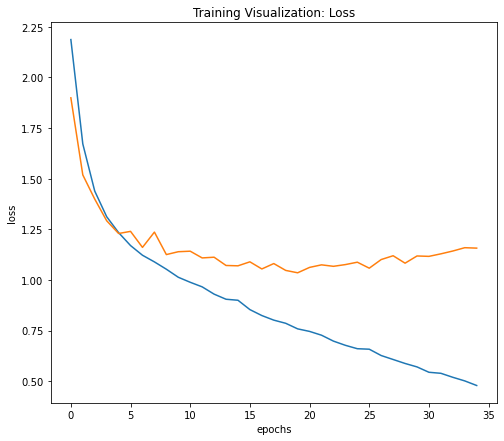

In [42]:
plt.figure(figsize = (8, 7))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training Visualization: Loss")
plt.show()

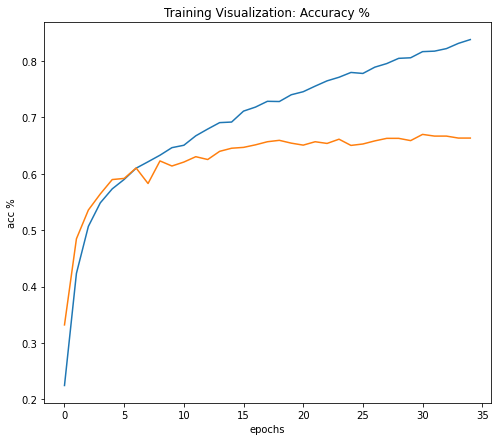

In [43]:
plt.figure(figsize = (8, 7))
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Training Visualization: Accuracy %")
plt.show()

In [62]:
import plotly.graph_objs as go
# import plotly.plotly as py
import plotly.express as px
import plotly

In [45]:
with h5py.File("3D_MNIST-archive/train_point_clouds.h5", "r") as points_dataset:        
    digits = []
    for i in range(10):
        digit = (
            points_dataset[str(i)]["img"][:], 
            points_dataset[str(i)]["points"][:], 
            points_dataset[str(i)].attrs["label"]
        )
        
        digits.append(digit)
        

In [46]:
len(digits)

10

In [49]:
len(digits[0])

3

In [65]:
digits[0][0].shape, digits[0][1].shape, digits[0][2].shape

((30, 30), (25700, 3), ())

In [66]:
# Img-
digits[0][0].shape

(30, 30)

In [67]:
# Points in point cloud-
digits[0][1].shape
# Consists of (x, y, z) coordinates, a tuple of length 3.

(25700, 3)

In [68]:
# Label-
digits[0][2]

5

In [69]:
for r in digits[0][1]:
    break

In [70]:
r.shape

(3,)

In [71]:
r

array([ 0.15      , -0.1094358 ,  0.47305447])

In [51]:
x_c = [r[0] for r in digits[0][1]]
y_c = [r[1] for r in digits[0][1]]
z_c = [r[2] for r in digits[0][1]]

In [54]:
len(x_c), len(y_c), len(z_c)

(25700, 25700, 25700)

In [55]:
trace1 = go.Scatter3d(
    x=x_c, y=y_c,
    z=z_c, mode='markers', 
    marker = dict(
        size=12, color=z_c,
        colorscale='Viridis', opacity=0.7
    )
)

In [56]:
data = [trace1]
layout = go.Layout(
    height = 500, width = 600,
    title = "Digit: " + str(digits[0][2]) + " in 3D space"
)
fig = go.Figure(data = data, layout = layout)

In [ ]:
fig.show()

In [84]:
digits[0][1].shape

(25700, 3)

In [74]:
digits[0][1][:, 0].shape

(25700,)

In [ ]:
fig = px.scatter_3d(
    digits[0][1], x = digits[0][1][:, 0],
    y = digits[0][1][:, 1], z = digits[0][1][:, 2],
    color = digits[0][1][:, 2]
)

fig.show()